# [IAPR 2018:][iapr2018] Lab 1 ‒  Image segmentation

**Author:** Ibrahim Youssef and Bryce Burgess 

**Due date:** 20.04.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

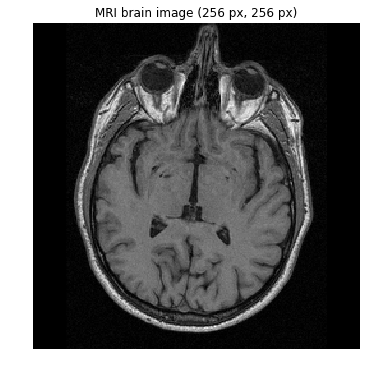

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Region growing is a fundamental method for image segmentation. The concept behind the method involves selecting a **seed** within the region of interest, and then recursively expanding until the object is identified. In order to better split the foreground from the backgound of the image, thresholding is generally done as a preliminary step. 

We began with the simple pre-processing step of median filtering to reduce the sharp transitions and reduce the amount of low intensity pixels found *inside* the brain. We then generated a set of markers for the brain and for the background. We defined the markers as pixel that could unambiguously be identified as belonging either to the brain image, or to the background. We were able to properly assign these markers using thresholding on the image's histogram. Pixels with extremely high intensities were considered as foreground, while those with extremely low intensities were labelled as background.

In order to optimally determine the threshold that distinguishes between foreground and background pixels on the histogram, we used the Otsu method. In order to be totally sure that our markers were correctly labelled, we introduced a buffer to ensure that only pixels with *extreme* values were used.

After generating our image markers, we used the watershed segmentation as our region growing method. This resulted in a binary image with pixels assigned to either foreground or background. We used binary morphology to close any remaining holes in the brain image.

Finally, the area of the brain (in pixels) was computed by counting the number of pixesl labelled as 1. With this method, we computed the brain to have a size of 32305  pixels, which corresponds to 49.3% of the total image.

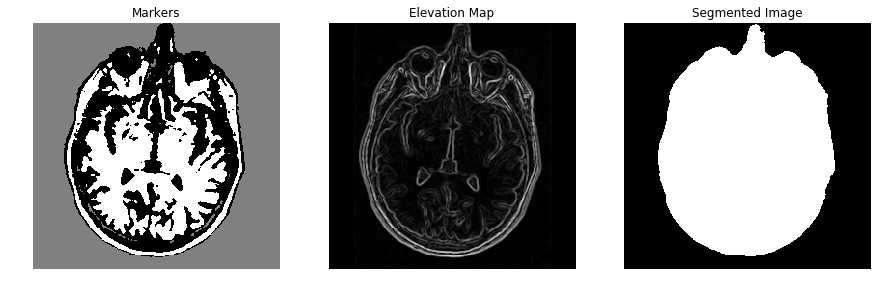


******************************************************
*  The brain in this image is  32305  pixels large.  *
*  The image is made up of 256x256 =  65536  pixels. *
*  This is  49.2935180664 % of the total image.      *
******************************************************


In [4]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.filters import median
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.morphology import watershed

# Create a 2D array of the same dimenions as the image, which will store the markers used in the watershed segmentation.
markers = np.zeros_like(brain_im)

# Median filter the original image to get rid of sharp transitions and reduce the low intensity pixels found inside the brain.
filtered_brain_im = median(brain_im)

# Set a threshold.
threshold = threshold_otsu(filtered_brain_im)

# The buffer is used to help generate markers that are distincly foreground or background.
buffer = 30

# Generate the makers based on the threshold obtained using Otsu's method. 
markers[filtered_brain_im < threshold - buffer] = 1
markers[filtered_brain_im > threshold + buffer] = 2

# Generate an elevation map of the brain image using the sobel filter.
elevation_map = sobel(filtered_brain_im)

# Perform the segmentation on the elevation map, using the computed markers as starting points for the watershed algorithm.
segmentation = watershed(elevation_map, markers)

# Mathematical morphology to remove holes
segmentation = ndi.binary_fill_holes(segmentation - 1)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(15, 7))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(1, 3, 2, adjustable='box-forced')
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box-forced')

ax[0].imshow(markers, cmap=plt.cm.gray)
ax[0].set_title('Markers')
ax[0].axis('off')

ax[1].imshow(elevation_map, cmap=plt.cm.gray)
ax[1].set_title('Elevation Map')
ax[1].axis('off')

ax[2].imshow(segmentation, cmap=plt.cm.gray)
ax[2].set_title('Segmented Image')
ax[2].axis('off')

plt.show()

# Finally, compute the size of the brain by counting all pixels labelled with a "1"
brain_size = sum(sum(segmentation))
image_size = im_h*im_w
percent = 100.0*(float(brain_size)/float(image_size))

# Report results
print
print "******************************************************"
print "*  The brain in this image is ",brain_size," pixels large.  *" 
print "*  The image is made up of 256x256 = ",image_size," pixels. *"
print "*  This is ", percent, "% of the total image.      *"
print "******************************************************"

### 1.3 Contour detection

Another powerful segmentation technique is contour detection. This method searches for sharp edges within the image, which can allow us to identify the object's perimiter and inner contours. We implemented an edge detector based on the Canny algorithm. 

One of the initial steps of the Canny edge detection is to apply a Gaussian filter to the image. This was done to smooth the image. A Gaussian filter with a larger standard deviation results in a *less* sensitive edge detector, while a smaller standard deviation is more sensitive to contours. A less sensitive edge detector does a better job of smoothing the image, and yielded better results in this case.

Since contour detection only identifies the image boundaries (and some internal contours) it was necessary to fill up the image. We utilized binary morphology in order to close up the holes within the identified contour.

With this method, we computed the brain to have a size of 32835 pixels, which corresponds to 50.1% of the total image.

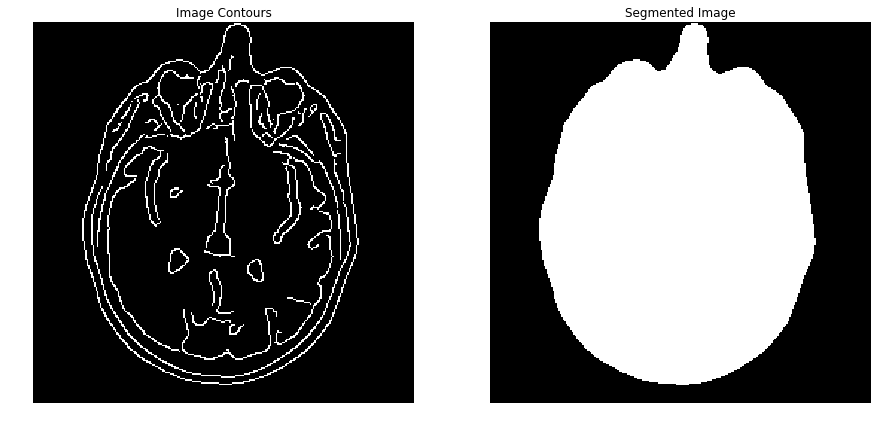


******************************************************
*  The brain in this image is  32835  pixels large.  *
*  The image is made up of 256x256 =  65536  pixels. *
*  This is  50.1022338867 % of the total image.      *
******************************************************


In [5]:
from skimage.feature import canny

# Use the Canny edge detector in order to identify the edges of the brain image.
edges = canny(brain_im, sigma=2)

# Fill the holes that remain within the brain image using mathematical morphology.
filled_brain = ndi.binary_fill_holes(edges)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(15, 7))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1, adjustable='box-forced')
ax[1] = plt.subplot(1, 2, 2, adjustable='box-forced')

ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].set_title('Image Contours')
ax[0].axis('off')

ax[1].imshow(filled_brain, cmap=plt.cm.gray)
ax[1].set_title('Segmented Image')
ax[1].axis('off')

plt.show()

# Finally, compute the size of the brain by counting all pixels labelled with a "1"
brain_size = sum(sum(filled_brain))
image_size = im_h*im_w
percent = 100.0*(float(brain_size)/float(image_size))

# Report results
print
print "******************************************************"
print "*  The brain in this image is ",brain_size," pixels large.  *" 
print "*  The image is made up of 256x256 = ",image_size," pixels. *"
print "*  This is ", percent, "% of the total image.      *"
print "******************************************************"

### 1.4 Simple Thresholding

Thresholding is one of the simplest methods available for segmenting an image, and can be effective in certain specific cases. Thresholding is a limited method in terms of what it can be used to achieve. It can **only** separate foreground from background, and can not be used to reliably define objects. Though it works well in this case, this method will not always yield as accurate an area estimate as the region growing or contouring methods. However, it can be useful in generating a fairly close approximation with lower computational cost.

Since this image consists of a single object, it was possible to set an intensity threshold that separated the brain scan from the rest of the image. We then computed the size of the brain by counting the number of pixels that were labelled as foreground. We selected the threshold algorimthmically using Li’s Minimum Cross Entropy method. Using this threshold, a binary image was created that assigned pixels to either the foreground or the background. 

Since many pixels within the brain image had low intensity values, we performed binary morphology to close any remaining holes in the image. The result is a near-perfectly segmented binary image, and an area estimate almost identical to those computed via region growing and contouring. With this method, we computed the brain to have a size of 32972 pixels, which corresponds to 50.3% of the total image. 

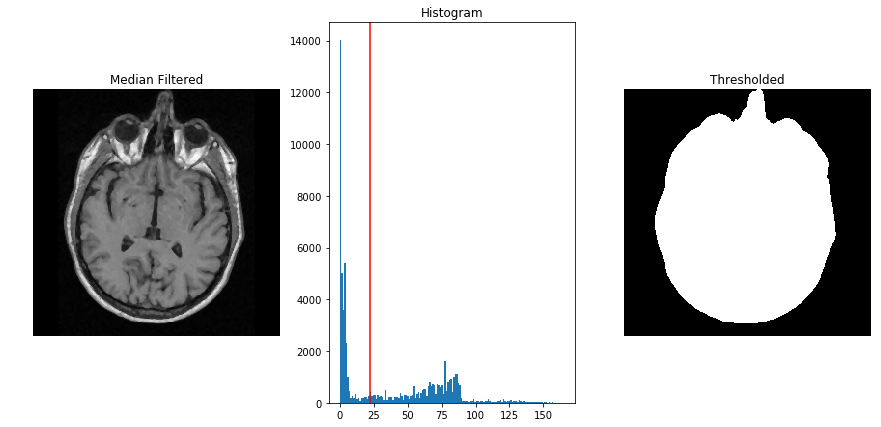


******************************************************
*  The brain in this image is  32972  pixels large.  *
*  The image is made up of 256x256 =  65536  pixels. *
*  This is  50.3112792969 % of the total image.      *
******************************************************


In [6]:
from skimage.filters import threshold_li

# Generate a histogram of the image data.
nb_bins = 150

# Set a threshold.
threshold = threshold_li(filtered_brain_im)

# Label each pixel as part of the foreground, or as part of the background.
binary = filtered_brain_im > threshold

# Mathematical morphology to remove holes
binary = ndi.binary_fill_holes(binary)

fig, axes = plt.subplots(ncols=3, figsize=(15, 7))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(1, 3, 2, adjustable='box-forced')
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box-forced')

ax[0].imshow(filtered_brain_im, cmap=plt.cm.gray)
ax[0].set_title('Median Filtered')
ax[0].axis('off')

ax[1].hist(filtered_brain_im.ravel(), bins=nb_bins)
ax[1].set_title('Histogram')
ax[1].axvline(threshold, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

# Finally, compute the size of the brain by counting all pixels labelled with a "1"
brain_size = sum(sum(binary))
image_size = im_h*im_w
percent = 100.0*(float(brain_size)/float(image_size))

# Report results
print
print "******************************************************"
print "*  The brain in this image is ",brain_size," pixels large.  *" 
print "*  The image is made up of 256x256 = ",image_size," pixels. *"
print "*  This is ", percent, "% of the total image.      *"
print "******************************************************"

## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [7]:
# Load images. Make sure they are in the LAB color space
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)

number_of_images = images.shape[0]
axis_1_length = images.shape[1]
axis_2_length = images.shape[2]
number_of_color_channels = images.shape[-1]
print('Number of images: ', number_of_images)
print('Image size: {}, {} '.format(axis_1_length, axis_2_length))
print('Number of color channels: ', number_of_color_channels)
print "The RGB values are of the", type(images[0,0,0,2]), "data type."

#for i in range(0, images.shape[0]):
#    ima = (images[i] + [0.0, 128.0, 128.0]) / [100.0, 255.0, 255.0]
#    images[i] = skimage.color.rgb2lab(ima)

('Number of images: ', 4L)
Image size: 480, 640 
('Number of color channels: ', 3L)
The RGB values are of the <type 'numpy.uint8'> data type.


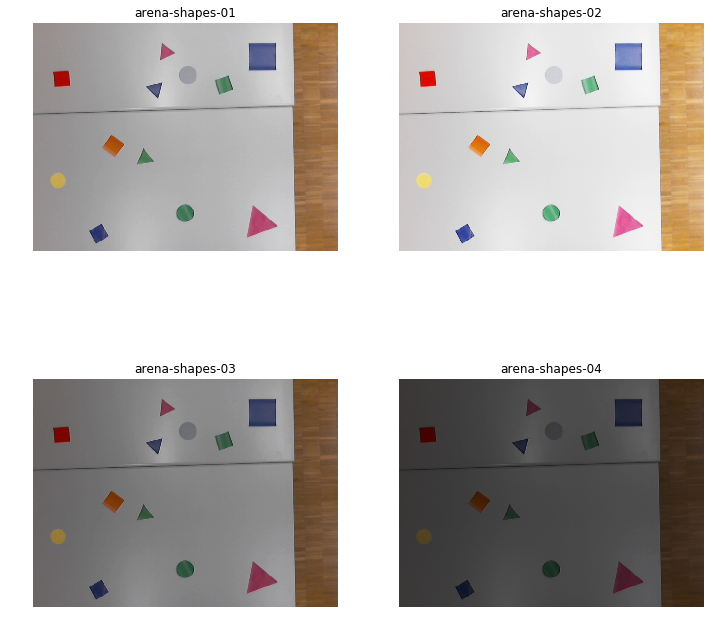

In [8]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im, cmap='jet')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

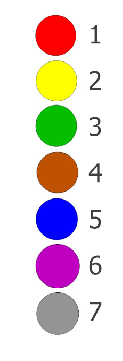

In [9]:
# Load and plot palette.
palette = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(palette)
ax.axis('off')
plt.show()

### 2.2 Intensity Normalization
Our goal was to develop a single routine that yielded the *same* results for the four given images. Since the illumination of the four images varied significantly, we began our processing with a normalization step. This generated a set of images that were very similar in terms of illumination and contrast. Though not entirely identical, these four images were now similar enough to allow a single routine to output very similar results. Our normalization method consisted of two steps; we first rescaled the image intensities, and then applied adaptive histogram equalization.

We rescaled the image intensities in order to shrink the intensity levels of the four images eliminate certain low and high intensity values for the pixesl of each channel. The image was rescaled to include only intensities that were within the 0.1th and 70th percentiles for each channel. This allowed us to equalize the cross-image intensities quite well. Used alone however, this method did not optimize the contrasts within each individual image. Additionally, the original color scheme of each image was distorted as a result of the intensity shrinking. In order to compensate for this, we followed this step with an adaptive histogram equalization.

Adaptive histogram equalization is a process similar to normal histogram equalization, but it does not operate on a single histogram of the entire image. Instead this algorithm breaks down the image into sections, and then equalizes the histograms of those individual sections. This technique helped enhance the *local* contrasts within each of our four images. Since the individual images were not uniformly illuminated, adaptive histogram equalization allowed us to yield images with greatly improved contrasts. 

Using a combination of intensity rescaling and adaptive histogram equalization, we were able to normalize the four differently illuminated images and process them using a single routine.



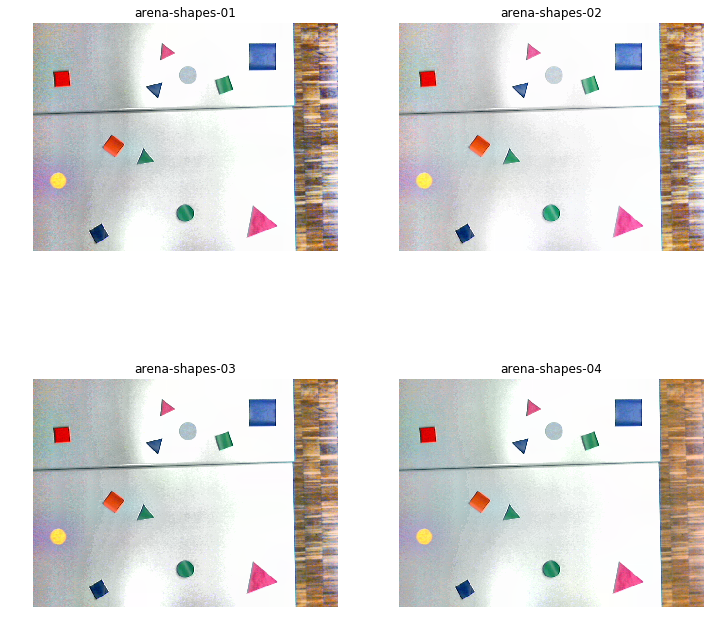

In [10]:
from skimage import exposure

# Intensity equalization is done for each channel in the images.
images_equalized = np.empty(images.shape)

# Specify the upper and lower percentile levels and clip limit
p_up = 70
p_low = 0.1
clip_lim = 0.025

for i in range(0,number_of_images):
    
    # Contrast stretching.
    p_lower_ch1, p_upper_ch1 = np.percentile(images[i,:,:,0], (p_low, p_up))
    p_lower_ch2, p_upper_ch2 = np.percentile(images[i,:,:,1], (p_low, p_up))
    p_lower_ch3, p_upper_ch3 = np.percentile(images[i,:,:,2], (p_low, p_up))
    
    # Rescale the image intensity for each channel
    img_rescale_channel_1 = exposure.rescale_intensity(images[i,:,:,0], in_range=(p_lower_ch1, p_upper_ch1))
    img_rescale_channel_2 = exposure.rescale_intensity(images[i,:,:,1], in_range=(p_lower_ch2, p_upper_ch2))
    img_rescale_channel_3 = exposure.rescale_intensity(images[i,:,:,2], in_range=(p_lower_ch3, p_upper_ch3))
    
    # Equalize the histograms
    channel_1_eqd = skimage.exposure.equalize_adapthist(img_rescale_channel_1, clip_limit = clip_lim)
    channel_2_eqd = skimage.exposure.equalize_adapthist(img_rescale_channel_2, clip_limit = clip_lim)
    channel_3_eqd = skimage.exposure.equalize_adapthist(img_rescale_channel_3, clip_limit = clip_lim)
    
    # Group the three channels into a single image again.
    images_equalized[i,:,:,0] = channel_1_eqd
    images_equalized[i,:,:,1] = channel_2_eqd
    images_equalized[i,:,:,2] = channel_3_eqd

# The equalized images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_equalized, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.3 Extracting Color Patches
In order to identify the number of shapes of each color, we made use of the reference palette given. We began by extracting square patches of pure color for each of the seven colors given. In order to simplify this step, we cropped out the numbers on the right-hand side of the color palette. We then extracted 7 differently colored squares of equal size. These were later used as references to identify the color of each shape. 


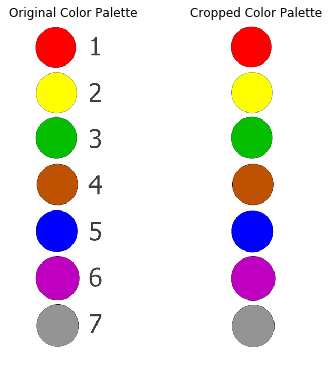

In [11]:
import skimage.util
import skimage.color

# Crop out the numbers, keeping only the colors
palette_crop = skimage.util.crop(palette, ((1, 1), (1, 50),(0,0)))

# Plot palette
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(palette)
ax[0].axis('off')
ax[0].set_title("Original Color Palette")

ax[1].imshow(palette_crop)
ax[1].axis('off')
ax[1].set_title("Cropped Color Palette")
plt.show()

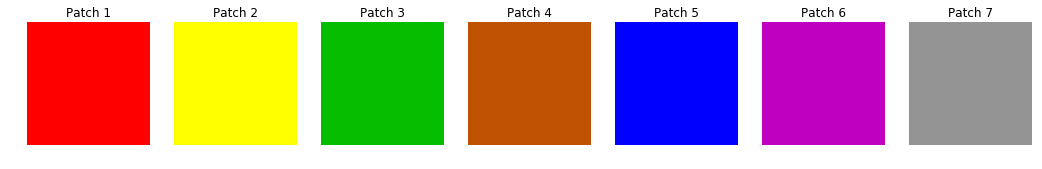

In [12]:
# Determine the pallete dimensions
palette_height = palette_crop.shape[0]
palette_width = palette_crop.shape[1]
palette_channels = palette_crop.shape[2]

# Select patches from within the 7 circles and add them to the palette_segments data structure
palette_segments = []
verticle_offset =  palette_height/7
horizontal_offset = palette_width/2

# Half the length of each square's side.
length = 20

for i in range (0,7):
    
    # The verticle and horizontal ranges to cut out from each circle. Store in a tuple organized as (lower_idx,higher_idx)
    verticle_range = ((horizontal_offset - length) + (verticle_offset*i), (verticle_offset*i) + horizontal_offset + length)
    horizontal_range = (horizontal_offset - length, horizontal_offset + length)
    
    # Extract a patch from each color in the palette.
    patch = palette_crop[verticle_range[0]:verticle_range[1],horizontal_range[0]:horizontal_range[1]]
    palette_segments.append(patch)
    
# Plot the seven different color segments
fig, axes = plt.subplots(1, len(palette_segments), figsize=(18,4))
for ax,patch,i in zip(axes.ravel(), palette_segments, range(0,len(palette_segments))):
    ax.imshow(patch)
    ax.axis('off')
    ax.set_title("Patch " + str(i + 1))
plt.show()
    
# Report the number of colors
number_of_colors = len(palette_segments)
col = ["Red", "Yellow", "Green", "Orange", "Blue", "Purple", "Gray"]
    

### 2.4 Segmentation via Contour Detection
After normalizing the images, and extracting patches of color from the color palette, we performed segmentation using the contour detection method. This was done to remove all parts of the images that were not closed shapes, but **could** still be given a color label by the color detection algorithm. Since the background of the images are colored, we wanted to avoid assigning color labels to any part of the image that was not strictly a shape. For example, the white-ish color of the background could be labelled as a grey object, and the brown tiles on the right could be identified as brown objects. 

To simplify the contour detection, we began by converting the images to grayscale. These grayscale images were then high-pass filtered in order to enhance the contours, thereby improving the segmentation. Following these pre-processing steps, we used a Canny edge detector to identify the contours of the images. This allowed us to determine the contours of the shapes, but also identified a number of contours that belonged to the background. Finally, we used binary morphology to fill the shapes and eliminate the unwanted contours. 

The segmentation resulted in a binary image for each colored picture. This binary was then used as a mask to guarentee that the parts of the images belonging to the background were not contenders in the color matching.

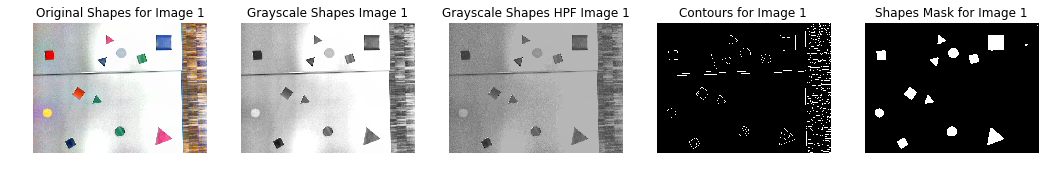

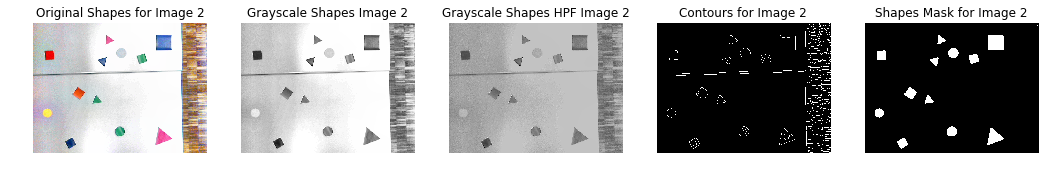

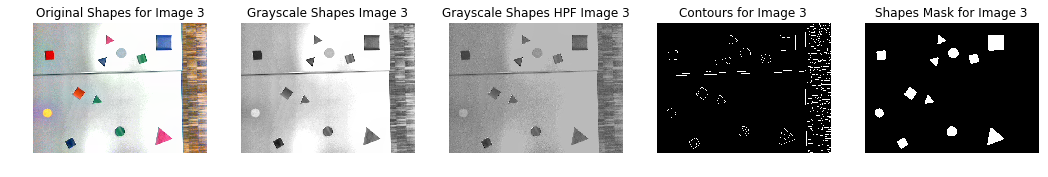

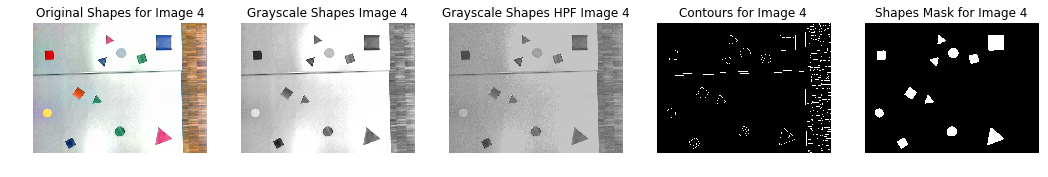

In [13]:
from skimage.feature import canny
from scipy import ndimage

# Generate a segmentation mask for each of the given images.
shapes_mask = np.empty((number_of_images, axis_1_length, axis_2_length)).astype(np.uint8)

image_filtered = np.empty((number_of_images, axis_1_length, axis_2_length))

for image_sel in range(0, number_of_images):

    # Select the image to process. Select image 1 - 4
    image = images_equalized[image_sel,:,:,:]

    # Convert the original image to grayscale
    image_gray = skimage.color.rgb2gray(image)

    # High pass filter to enhance the contours
    kernel_HPF = np.array([[1, -2, 1],
                           [-2,  6, -2],
                           [1, -2, 1]])
    image_filtered[image_sel] = ndimage.convolve(image_gray, kernel_HPF)

    # Use the Canny edge detector in order to identify the edges of the brain image.
    # Reduce the standard deviation in order to INCREASE the edge detector's sensitivity.
    edges = canny(image_filtered[image_sel], sigma=2.5)

    # Fill the holes that remain within the image using mathematical morphology.
    shapes_mask[image_sel] = ndi.binary_fill_holes(edges)

    # Using mathematical morphology, remove contours that were identified, but that are not for the shapes.
    shapes_mask[image_sel] = ndi.binary_opening(shapes_mask[image_sel])

    # Plot the results
    fig, ax = plt.subplots(1, 5, figsize=(18, 4))

    ax[0].imshow(image)
    ax[0].set_title('Original Shapes for Image '+ str(image_sel + 1))
    ax[0].axis('off')

    ax[1].imshow(image_gray, cmap='gray')
    ax[1].set_title('Grayscale Shapes Image '+ str(image_sel + 1))
    ax[1].axis('off')

    ax[2].imshow(image_filtered[image_sel], cmap='gray')
    ax[2].set_title('Grayscale Shapes HPF Image '+ str(image_sel + 1))
    ax[2].axis('off')

    ax[3].imshow(edges, cmap=plt.cm.gray)
    ax[3].set_title('Contours for Image ' + str(image_sel + 1))
    ax[3].axis('off')

    ax[4].imshow(shapes_mask[image_sel], cmap=plt.cm.gray)
    ax[4].set_title('Shapes Mask for Image ' + str(image_sel + 1))
    ax[4].axis('off')
    
    plt.show()

### 2.5 Sorting Shapes by Color

The next step in our routine was to sort each shape in the images by color. This was done by computing the Euclidean color difference between the images and each reference color.

We began this section of the routine by homogenizing the small color variations within each shape. In order to do this, we passed the images through a gaussian filter with a large standard deviation. This resulted in very blurry images that were more consistent in terms of color. We then needed to make sure that the blurring didn't cause any pixels outside the shape boundaries to be labelled as matches. To restict the pixels eligible for matching to only those within a shape, we used the binary masks obtained from the previous contouring step. Multiplying the elements of the mask and those of the image ensured that only pixels that *were* part of the shapes were contenders in the color matching. For each of the 7 color patches, we then computed the euclidean distance in the RGB color space for every pixel. 

$difference = \sqrt{(R_{image} - R_{reference})^2 + (G_{image} - G_{reference})^2 + (B_{image} - B_{reference})^2} $  

Pixels with distances below a certain threshold were considered as having matched with that reference color. Ultimately, we generated 7 binary images for each original image - one binary image per reference color. The pixesl for each of these seven images were labelled as '1' only if they unambiguously matched with the reference color. The pixels of each binary map were labelled as '0' otherwise. 

From the plotted results we can see that every shape in each of the 4 images were correctly labelled according to their color. This was done using the same routine for each of the four images. It is important to note that this part of the routine did *not* identify the shapes in their entirety. Its purpose was only to find clusters of pixels within each shape that unambiguously matched with a reference color. 

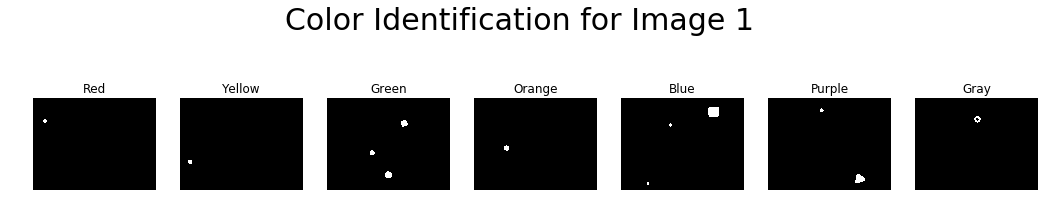

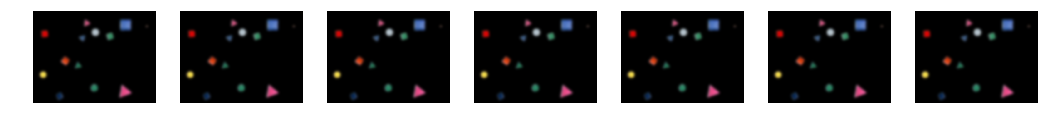

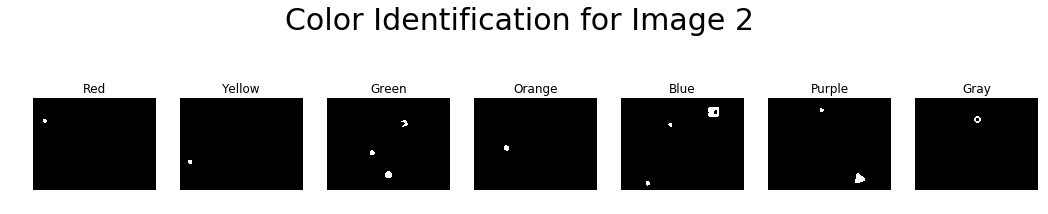

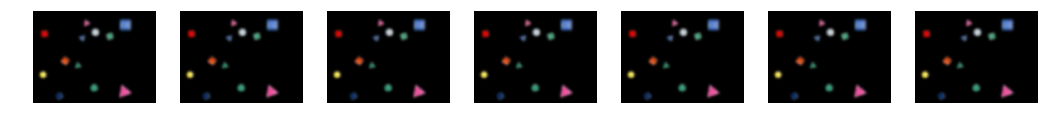

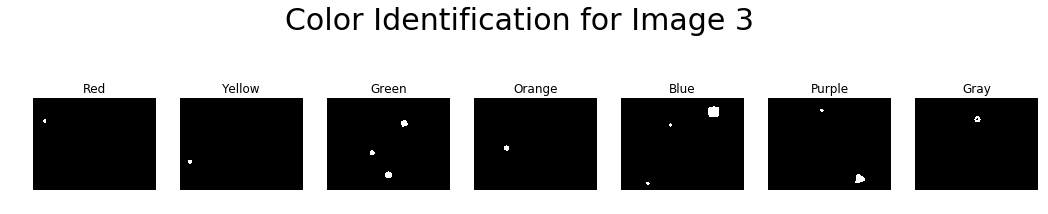

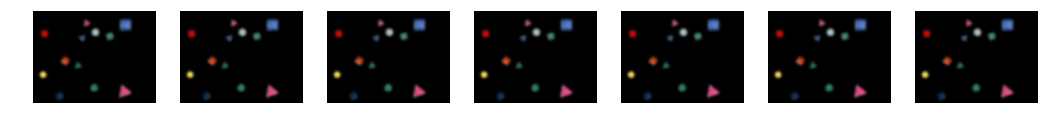

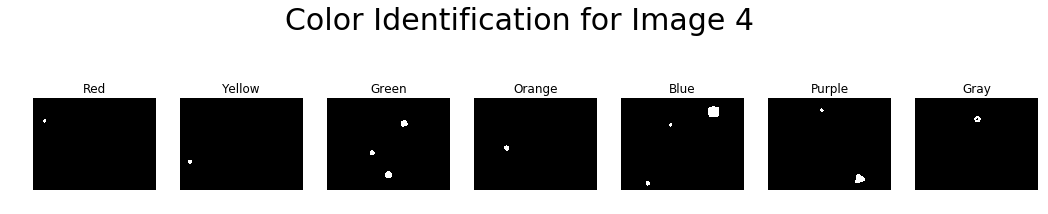

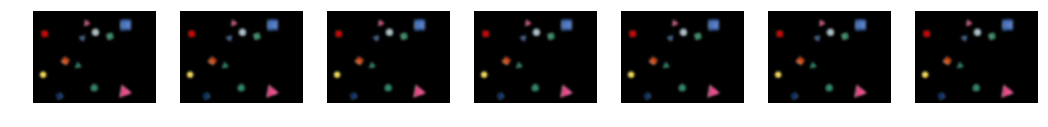

In [14]:
from skimage import transform
from scipy import ndimage
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral

# For each color from the palete, create a binary labelling for a unique color. Do this for each image given.
color_match = np.empty((number_of_images, len(palette_segments), axis_1_length, axis_2_length))

for image_sel in range(0, number_of_images):
    
    # Select the image to process. Select image 1 - 4
    image = images_equalized[image_sel,:,:,:]

    # Define a threshold for the color difference. Anything below the threhsold is considered a color match.
    # Each color has its own threshold, this is a limitation that could be improved upon.
    color_difference_threshold = [0.08, 0.3, 0.3, 0.05, 0.5, 0.28, 0.06]

    # A container for the color differences between the image and each reference color.
    color_difference = np.empty((axis_1_length, axis_2_length))

    # Set all pixels that are not part of shapes to 0
    processed_image = np.empty((axis_1_length, axis_2_length, number_of_color_channels))
    for i in range(0,image.shape[2]):
        processed_image[:,:,i] = shapes_mask[image_sel] * image[:,:,i]

    # Blur the image with a gaussian filter. this helps regularize the colors within each shape (makes the shape color more uniform).
    processed_image = skimage.filters.gaussian(processed_image, multichannel=True, sigma=7)

    # For each color patch, compute the color difference at each pixel in the images we are studying.
    # Label pixels with a small color difference as '1', and all others as '0'
    for i in range(0, number_of_colors):
    
        # Select the reference color (there are 7 in total)
        reference_color = palette_segments[i]

        # Ensure that the reference image is the same size as the image to be analyzed.
        reference_color_resized = skimage.transform.resize(reference_color, image.shape, mode='constant')
    
        # Compute the color difference between the reference and the image to be analyzed.
        for l in range(0,processed_image.shape[0]):
        
            for k in range(0,processed_image.shape[1]):
                color_difference[l, k] = np.square(reference_color_resized[l,k,0] - processed_image[l,k,0]) + np.square(reference_color_resized[l,k,1] - processed_image[l,k,1]) + np.square(reference_color_resized[l,k,2] - processed_image[l,k,2])
        
        # If the color difference is below the color threshold, we consider that object to be a color match
        color_match[image_sel, i,:,:] = color_difference <= color_difference_threshold[i]
    
        # Finally, use the segmentation mask to filter out any extra pixels that may be identified as matches due to the blurring
        color_match[image_sel, i,:,:] = shapes_mask[image_sel] * color_match[image_sel, i,:,:]
    
    # Plot results
    fig, axes = plt.subplots(1, number_of_colors, figsize=(18, 4))
    plt.suptitle('Color Identification for Image ' + str(image_sel + 1), fontsize=30)
    for ax, im, i in zip(axes.ravel(), color_match[image_sel], range(0, len(palette_segments))):
        ax.imshow(im, cmap=plt.cm.gray)
        ax.axis('off')
        ax.set_title(col[i])

    # Plot the processed image as a reference to help verfy the colors were correctly identified
    fig, axes = plt.subplots(1, number_of_colors, figsize=(18,4))
    for ax,patch,i in zip(axes.ravel(), palette_segments, range(0,len(palette_segments))):
        ax.imshow(processed_image)
        ax.axis('off')
        
    plt.show()

### 2.6 Number of Shapes for Each Color

After having successfuly managed to identify the color of each shape, we proceeded to counting the number of shapes of each color. This was done using a blob detector based on the Laplacian of Gaussian (LoG) method. In order to avoid overcounting, we decreased the sensitivity of our blob detector by raising the minimum standard deviation for the Gaussian Kernal. 

The results of this step were identical for each of the four given images. We identified 1 red shape, 1 yellow shape, 3 green shapes, 1 orange shape, 3 blue shapes, 2 purple shapes, and 1 gray shape per image.

In [15]:
from skimage.feature import blob_log

# Implement this for each image
for image_sel in range(0, number_of_images):
    
    print "For image " + str(image_sel + 1) + ": \n"
    
    for c in range(0, number_of_colors):
    
        # Count the number of blobs in the color match array for each of the 7 colors.
        # We raise the minimum standard deviation for the Gaussian Kernel in order to avoid overcounting blobs.
        blobs = blob_log(color_match[image_sel,c,:,:], min_sigma=10)
        print "\tNumber of "+ col[c] +" shapes: " + str(blobs.shape[0])
         
    print "\n"


For image 1: 

	Number of Red shapes: 1
	Number of Yellow shapes: 1
	Number of Green shapes: 3
	Number of Orange shapes: 1
	Number of Blue shapes: 3
	Number of Purple shapes: 2
	Number of Gray shapes: 1


For image 2: 

	Number of Red shapes: 1
	Number of Yellow shapes: 1
	Number of Green shapes: 3
	Number of Orange shapes: 1
	Number of Blue shapes: 3
	Number of Purple shapes: 2
	Number of Gray shapes: 1


For image 3: 

	Number of Red shapes: 1
	Number of Yellow shapes: 1
	Number of Green shapes: 3
	Number of Orange shapes: 1
	Number of Blue shapes: 3
	Number of Purple shapes: 2
	Number of Gray shapes: 1


For image 4: 

	Number of Red shapes: 1
	Number of Yellow shapes: 1
	Number of Green shapes: 3
	Number of Orange shapes: 1
	Number of Blue shapes: 3
	Number of Purple shapes: 2
	Number of Gray shapes: 1




### 2.7 Total area (in pixels) of each color
Finally, we concluded our routine by computing the total area (in pixels) of each color. Previously in section 2.5, we successfuly labelled each shape with its correct color. This allowed us to create a binary image for each color, where each pixel with a value of '1' was guarenteed to be of the correct color. However as we saw, these binary images only identified *subsets* of the actual full shapes. Therefore we still needed to reconstruct the shapes of each binary image in order to compute the area of each color. 

This was done via morphological reconstruction. We used the incomplete binary images as seeds for each color. The shapes masks obtained previously were used to constrain the spread of the seeds. Morphological reconstruction allowed seeds with values of '1' to expand into regions with values of '0'. The expansion of higher-intensity pixels was limited by the shapes mask.

The resulting images show the reconstructed shapes for each color. The area was computed by counting the number of pixels with values of '1'. This process was done for each of the 4 given images. As we can see, variations in computed areas between the 4 images was minimal.

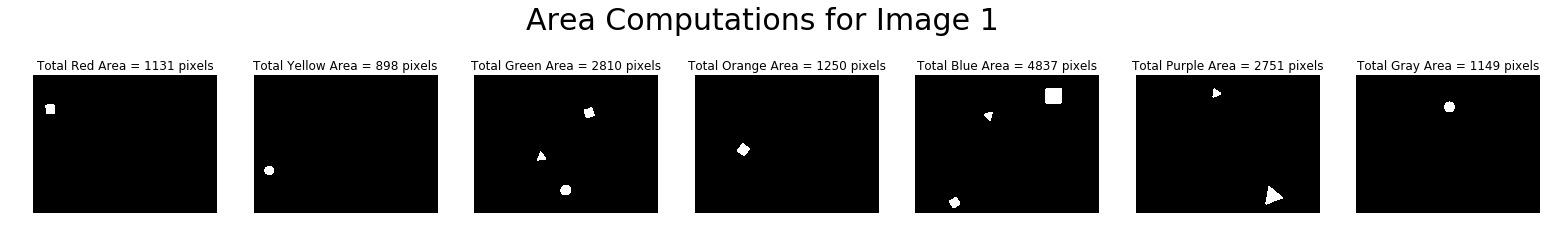

Total Area of Red shapes: 1131 pixels.
Total Area of Yellow shapes: 898 pixels.
Total Area of Green shapes: 2810 pixels.
Total Area of Orange shapes: 1250 pixels.
Total Area of Blue shapes: 4837 pixels.
Total Area of Purple shapes: 2751 pixels.
Total Area of Gray shapes: 1149 pixels.


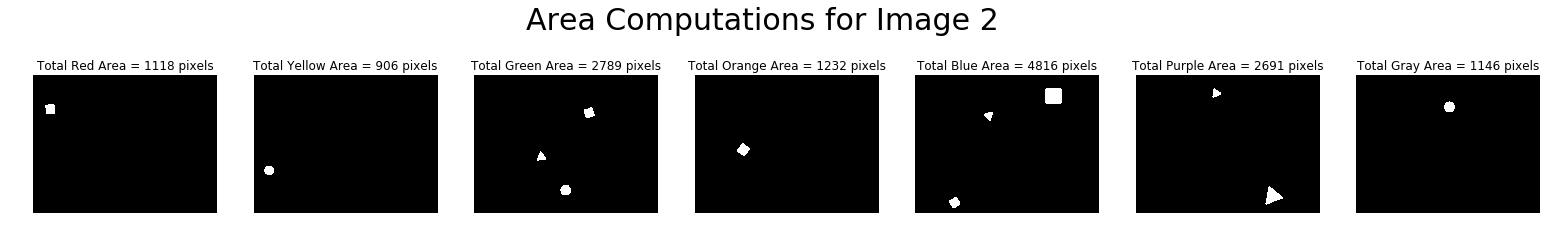

Total Area of Red shapes: 1118 pixels.
Total Area of Yellow shapes: 906 pixels.
Total Area of Green shapes: 2789 pixels.
Total Area of Orange shapes: 1232 pixels.
Total Area of Blue shapes: 4816 pixels.
Total Area of Purple shapes: 2691 pixels.
Total Area of Gray shapes: 1146 pixels.


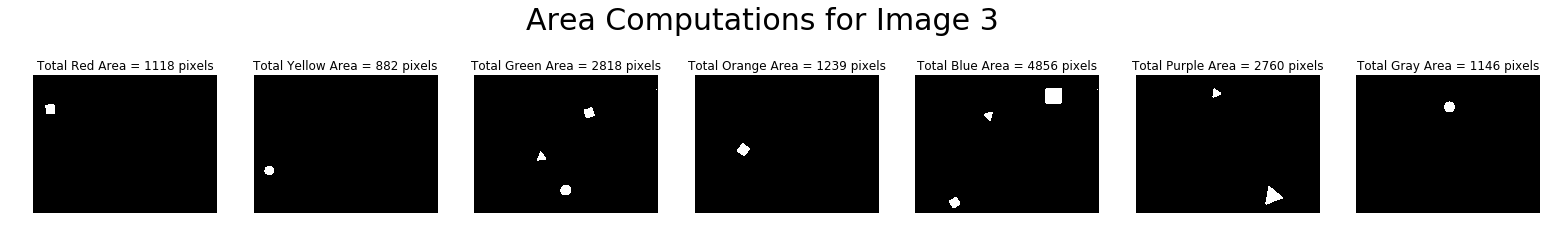

Total Area of Red shapes: 1118 pixels.
Total Area of Yellow shapes: 882 pixels.
Total Area of Green shapes: 2818 pixels.
Total Area of Orange shapes: 1239 pixels.
Total Area of Blue shapes: 4856 pixels.
Total Area of Purple shapes: 2760 pixels.
Total Area of Gray shapes: 1146 pixels.


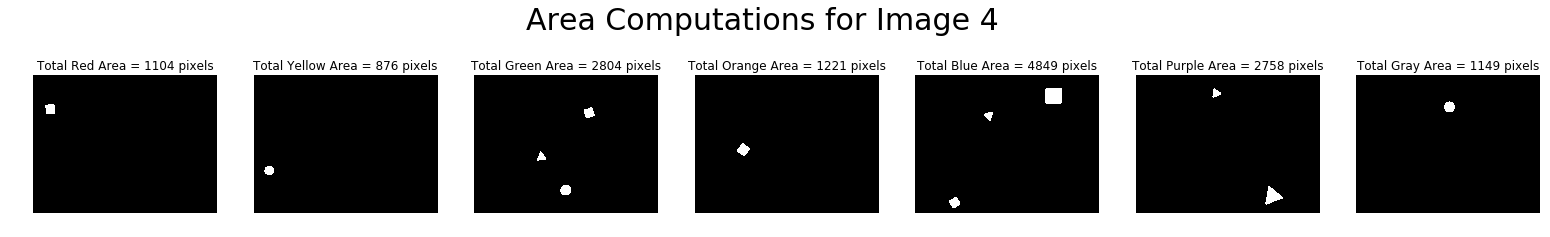

Total Area of Red shapes: 1104 pixels.
Total Area of Yellow shapes: 876 pixels.
Total Area of Green shapes: 2804 pixels.
Total Area of Orange shapes: 1221 pixels.
Total Area of Blue shapes: 4849 pixels.
Total Area of Purple shapes: 2758 pixels.
Total Area of Gray shapes: 1149 pixels.


In [16]:
from skimage.morphology import reconstruction
    
# Create a data structure to store all the pixels of each color. Do this for each of the 4 given images.
isolated_colors = np.empty((number_of_images, number_of_colors, axis_1_length, axis_2_length)).astype(np.uint8)
  
# Create a data structure to store the total areas per color. Do this for each of the 4 given images.
Areas = np.empty((number_of_images, number_of_colors)).astype(np.uint32)    
    
# For each image, identify the area (in pixels) of each color
for image_sel in range(0, number_of_images):
    
    # Using the color matches as a seed, reconstruct the shapes for each color. Reconstruction is constrained by the shapes mask.
    for c in range(0, number_of_colors):
        isolated_colors[image_sel,c,:,:] = reconstruction(color_match[image_sel,c,:,:], shapes_mask[image_sel])
        Areas[image_sel, c] = sum(sum(isolated_colors[image_sel,c,:,:]))
    
    # Plot the results
    fig, axes = plt.subplots(ncols=number_of_colors, figsize=(27, 4))
    plt.suptitle('Area Computations for Image ' + str(image_sel + 1), fontsize=30)
    for ax, im, c in zip(axes.ravel(), isolated_colors[image_sel], range(0, number_of_colors)):
        ax.imshow(im, cmap=plt.cm.gray)
        ax.axis('off')
        ax.set_title('Total ' + col[c] + ' Area = ' + str(Areas[image_sel,c]) + ' pixels')
    plt.show()
    
    # Report the results
    for c in range(0,number_of_colors):
        print "Total Area of "+ col[c] +" shapes: " + str(Areas[image_sel,c]) + " pixels."

### Conclusion

Using our routine, we were able to correctly detect the number of shapes of each color. This was done for each of the four images provided for analysis using a *single* processing routine.

We were also able to compute the total area (in pixels) of each color. This was also done for each of the four input images with a single routine. Additionally, the area estimates varied only slightly between the four images. This indicates that our method was robust enough to accomodate variations in light intensities.